Лабораторная работа 2. Провести предобработку данных. Разбить на тестовую и обучающую выборки (не забыть про кросс-валидацию).

In [18]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold

import json
import csv

from prefs import prefs

INPUT_JSON = "data/full_data.json"
OUTPUT_CSV = "data/osm_nodes.csv"

Загрузка данных

In [19]:
with open(INPUT_JSON, "r", encoding="utf-8") as f:
    data = json.load(f)

nodes = [el for el in data.get("elements", []) if el.get("type") == "node"]

tag_keys = []
for node in nodes:

    x = node.get("tags", {}).get("tourism", {})
    if x == "yes":
        tag_keys.append("tourism")
    elif x != "no":
        tag_keys.append(node.get("tags", {}).get("tourism", {}))
    
    x = node.get("tags", {}).get("historic", {})
    if x == "yes":
        tag_keys.append("historic")
    elif x != "no":
        tag_keys.append(node.get("tags", {}).get("historic", {}))

    x = node.get("tags", {}).get("amenity", {})
    if x == "yes":
        tag_keys.append("amenity")
    elif x != "no":
        tag_keys.append(node.get("tags", {}).get("amenity", {}))

    x = node.get("tags", {}).get("leisure", {})
    if x == "yes":
        tag_keys.append("leisure")
    elif x != "no":
        tag_keys.append(node.get("tags", {}).get("leisure", {}))

tags = set()
for i in tag_keys:
    if i != {}:
        tags.add(i)

print("Всего тегов:",len(tags))
print("Теги:",tags)



Всего тегов: 79
Теги: {'viewpoint', 'train', 'theme_park', 'vehicle', 'locomotive', 'water_park', 'shield', 'guest_house', 'zoo', 'dog_park', 'fountain', 'picnic_site', 'anchor', 'manor', 'technical_monument', 'hostel', 'wreck', 'historic', 'picnic_table', 'monument', 'tomb', 'motel', 'cannon', 'aircraft', 'gate', 'ruins', 'ship', 'museum', 'castle', 'hotel', 'gallery', 'chalet', 'wayside_cross', 'railway_station', 'attraction', 'apartment', 'hospital', 'training', 'binoculars', 'epigraph', 'garden', 'tank', 'propeller', 'archaeological_site', 'mine', 'social_facility', 'cafe', 'city_gate', 'church', 'dormitory', 'camp_site', 'battlefield', 'suburb', 'library', 'sauna', 'amusement_arcade', 'missile', 'railway_car', 'trail_riding_station', 'swimming_pool', 'boundary_stone', 'cross', 'restaurant', 'memorial', 'milestone', 'information', 'stone', 'printing_press', 'place_of_worship', 'lean_to', 'bench', 'grave', 'statue', 'artwork', 'wayside_shrine', 'aquarium', 'caravan_site', 'exhibit',

Преобразование в CSV

In [20]:
fieldnames = ["id", "lat", "lon", "name", "description", "inscription"] + sorted(tags)

with open(OUTPUT_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()

    for node in nodes:
        row = {
            "id": node.get("id"),
            "lat": node.get("lat"),
            "lon": node.get("lon")
        }
        row["name"] = node.get("tags").get("name")
        row["description"] = node.get("tags").get("description")
        row["inscription"] = node.get("tags").get("inscription")
        

        if row["name"] == None:
            row["name"] = row["description"]

        if row["description"] == None:
            row["description"] = row["inscription"]

        if row["inscription"] == None:
            row["inscription"] = row["name"]

        if row["description"] == None:
            row["description"] = row["inscription"]
        
        if row["name"] == None:
            row["name"] = "Место-сюрприз"
        if row["description"] == None:
            row["description"] = "Место-сюрприз"
        if row["inscription"] == None:
            row["inscription"] = "Место-сюрприз"

        for key in tags:
            if(node.get("tags", {}).get(key, "")):
                row[key] = True
            else:
                row[key] = False
        writer.writerow(row)

print(f"Сохранено {len(nodes)} нод в {OUTPUT_CSV}")

Сохранено 7266 нод в data/osm_nodes.csv


In [21]:
df = pd.read_csv(OUTPUT_CSV, encoding="utf-8")

# df[binary_cols] = df[binary_cols].astype("int8")

df.info()
df.head()

# base_cols = {"id", "lat", "lon", "name", "description", "inscription"}
# binary_cols = [c for c in df.columns if c not in base_cols]
# df[binary_cols].sum().sort_values(ascending=False).head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7266 entries, 0 to 7265
Data columns (total 85 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    7266 non-null   int64  
 1   lat                   7266 non-null   float64
 2   lon                   7266 non-null   float64
 3   name                  7266 non-null   object 
 4   description           7266 non-null   object 
 5   inscription           7266 non-null   object 
 6   aircraft              7266 non-null   bool   
 7   amusement_arcade      7266 non-null   bool   
 8   anchor                7266 non-null   bool   
 9   apartment             7266 non-null   bool   
 10  aquarium              7266 non-null   bool   
 11  archaeological_site   7266 non-null   bool   
 12  artwork               7266 non-null   bool   
 13  attraction            7266 non-null   bool   
 14  battlefield           7266 non-null   bool   
 15  bench                

,id,lat,lon,name,description,inscription,aircraft,amusement_arcade,anchor,apartment,...,trail_riding_station,train,training,vehicle,viewpoint,water_park,wayside_cross,wayside_shrine,wreck,zoo
0,2,59.771793,30.326110,Центр круглого зала,Центр круглого зала,Центр круглого зала,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,238809,60.189557,29.700233,Башмаки неизвестного дачника (2009),Башмаки неизвестного дачника (2009),Башмаки неизвестного дачника (2009),False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,21626280,59.946264,30.395801,В. И. Ленин,В. И. Ленин,В. И. Ленин,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,21751966,60.039200,30.296405,Озёрная,Озёрная,Озёрная,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,80317281,59.970296,30.386136,М. И. Калинин,М. И. Калинин,М. И. Калинин,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Добавление столбца Score

In [22]:
import random
random.seed(10)

poi_cols = [col for col in prefs.keys() if col in df.columns]

poi_matrix = df[poi_cols]

weights = pd.Series([prefs[col] for col in poi_cols], index=poi_cols)

df['score'] = poi_matrix.dot(weights) + random.uniform(-2.0, 2.0)

df[['id', 'name', 'score'] + poi_cols].head()

,id,name,score,historic,archaeological_site,ruins,battlefield,memorial,milestone,boundary_stone,...,cross,wayside_shrine,tomb,grave,attraction,picnic_site,picnic_table,trail_riding_station,suburb,sauna
0,2,Центр круглого зала,2.28561,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,238809,Башмаки неизвестного дачника (2009),0.28561,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,21626280,В. И. Ленин,4.28561,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,21751966,Озёрная,3.28561,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,80317281,М. И. Калинин,4.28561,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [23]:
df[['id', 'name', 'score']].sort_values('score', ascending=False).head(10)

,id,name,score
3507,7548851416,Город Пушкин,6.28561
3489,7485870895,Часовня святого благоверного князя Игоря Черни...,6.28561
5335,10915989243,Проспект Ю. Гагарина,6.28561
343,1280066306,"ДОТ ""Миллионер""",6.28561
243,1123474657,Памятник императору Николаю I,5.28561
224,1041154862,Пётр I,5.28561
6,242160221,Родина-Мать,5.28561
8,249082841,Петру Великому,5.28561
379,1312226165,Александру III,5.28561
4517,9352981941,Место-сюрприз,4.28561


Разбиение на тестовую и обучающую выборки

In [24]:
train_idx, test_idx = train_test_split(
    df.index,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

df['split'] = 'train'
df.loc[test_idx, 'split'] = 'test'
df['split'].value_counts()

split
train    5812
test     1454
Name: count, dtype: int64

In [25]:
N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

df['fold'] = -1

for fold_number, (_, test_idx) in enumerate(kf.split(df)):
    df.loc[test_idx, 'fold'] = fold_number

df['fold'].value_counts().sort_index()

fold
0    1454
1    1453
2    1453
3    1453
4    1453
Name: count, dtype: int64

In [26]:
train_df = df[df['fold'] != 2]
test_df  = df[df['fold'] == 2]

X_train = train_df[poi_cols]
y_train = train_df['score']

X_test = test_df[poi_cols]
y_test = test_df['score']

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

Лабораторная работа 3. Реализовать модель на обучающей выборке. Поэкспериментировать с разными параметрами. Сделать выводы. Не менее 10 экспериментов.

В третьей лабораторной обязательно провести следующие эксперименты:
1. Простой запуск с базовой настройкой
2. Изменение количества эпох (3 варианта)
3. Изменение количества batch_size (3 варианта)
4. Изменение learning_rate или аналогичного по значению параметра
5. Эксперименты с функциями активации (2 варианта)
6. Эксперименты с архитектурой сети (меняем количество и порядок слоев) (3 варианта)

По каждому эксперименту делаете вывод и собираете комбинацию их лучших экспериментов, по ней тоже делаете вывод

1. Простой запуск с базовой настройкой

In [27]:
print(X_train)
print(X_train.dtypes)
print(y_train.dtypes)

      historic  archaeological_site  ruins  battlefield  memorial  milestone  \
0          1.0                  0.0    0.0          0.0       0.0        0.0   
1          0.0                  0.0    0.0          0.0       0.0        0.0   
2          1.0                  0.0    0.0          0.0       1.0        0.0   
3          0.0                  0.0    0.0          0.0       0.0        0.0   
4          1.0                  0.0    0.0          0.0       1.0        0.0   
...        ...                  ...    ...          ...       ...        ...   
7257       0.0                  0.0    0.0          0.0       0.0        0.0   
7259       0.0                  0.0    0.0          0.0       0.0        0.0   
7260       0.0                  0.0    0.0          0.0       0.0        0.0   
7262       1.0                  0.0    0.0          0.0       0.0        0.0   
7264       0.0                  0.0    0.0          0.0       0.0        0.0   

      boundary_stone  epigraph  museum 

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import time

input_dim = X_train.shape[1]  # количество признаков

results = {}

# ТЕСТ 1 - БАЗОВЫЙ ЗАПУСК (Эпохи: 50, batch_size: 32, learning_rate: 0.001, функция_активации: ReLU, архитектура_сети: 32-16-1)

start_time = time.time()

model = Sequential([
    Dense(32, activation='relu', input_dim=input_dim),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"1. Базовый_запуск:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["1. Базовый_запуск"] = [training_time, test_loss, test_mae]

Epoch 1/50


c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.1723 - mae: 1.2452 - val_loss: 0.3697 - val_mae: 0.5108
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1210 - mae: 0.2318 - val_loss: 0.0127 - val_mae: 0.0284
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081 - mae: 0.0176 - val_loss: 0.0067 - val_mae: 0.0199
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - mae: 0.0100 - val_loss: 0.0047 - val_mae: 0.0110
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012 - mae: 0.0056 - val_loss: 0.0040 - val_mae: 0.0059
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5794e-04 - mae: 0.0048 - val_loss: 0.0036 - val_mae: 0.0062
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4111e-04 - mae: 0.0041 - val_loss: 0.0036 - val_mae: 0.0045
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3817e-04 - mae: 0.0027 - val_loss: 0.0035 - val_mae: 0.0052
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - l

In [29]:
# ТЕСТ 2 - Эпохи: 5

start_time = time.time()

model = Sequential([
    Dense(32, activation='relu', input_dim=input_dim),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"2. Эпохи: 5:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["2. Эпохи: 5"] = [training_time, test_loss, test_mae]

Epoch 1/5


c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.5226 - mae: 1.3166 - val_loss: 0.5532 - val_mae: 0.6696
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2829 - mae: 0.4412 - val_loss: 0.0563 - val_mae: 0.1830
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0302 - mae: 0.1080 - val_loss: 0.0131 - val_mae: 0.0653
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0094 - mae: 0.0388 - val_loss: 0.0058 - val_mae: 0.0228
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0043 - mae: 0.0151 - val_loss: 0.0042 - val_mae: 0.0128
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029 - mae: 0.0110 
2. Эпохи: 5:
TIME: 2.105325698852539
MSE: 0.0029
MAE: 0.0110


In [30]:
# ТЕСТ 3 - Эпохи: 1

start_time = time.time()

model = Sequential([
    Dense(32, activation='relu', input_dim=input_dim),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=1,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"3. Эпохи: 1:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["3. Эпохи: 1"] = [training_time, test_loss, test_mae]

c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7383 - mae: 0.8873 - val_loss: 0.1234 - val_mae: 0.3252
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1211 - mae: 0.3224 
3. Эпохи: 1:
TIME: 1.187133550643921
MSE: 0.1211
MAE: 0.3224


In [31]:
# ТЕСТ 4 - batch_size: 16

start_time = time.time()

model = Sequential([
    Dense(32, activation='relu', input_dim=input_dim),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"4. batch_size: 16:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["4. batch_size: 16"] = [training_time, test_loss, test_mae]

Epoch 1/50


c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.1310 - mae: 1.2237 - val_loss: 0.3119 - val_mae: 0.5158
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1077 - mae: 0.2516 - val_loss: 0.0149 - val_mae: 0.0645
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0076 - mae: 0.0220 - val_loss: 0.0058 - val_mae: 0.0176
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0033 - mae: 0.0107 - val_loss: 0.0048 - val_mae: 0.0137
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021 - mae: 0.0061 - val_loss: 0.0047 - val_mae: 0.0088
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0015 - mae: 0.0048 - val_loss: 0.0045 - val_mae: 0.0054
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011 - mae: 0.0043 - val_loss: 0.0044 - val_mae: 0.0055
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5369e-04 - mae: 0.0039 - val_loss: 0.0043 - val_mae: 0.0051
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2

In [32]:
# ТЕСТ 5 - batch_size: 8

start_time = time.time()

model = Sequential([
    Dense(32, activation='relu', input_dim=input_dim),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"5. batch_size: 8:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["5. batch_size: 8"] = [training_time, test_loss, test_mae]

Epoch 1/50


c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6022 - mae: 0.3335 - val_loss: 0.0088 - val_mae: 0.0288
Epoch 2/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0039 - mae: 0.0117 - val_loss: 0.0071 - val_mae: 0.0091
Epoch 3/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0021 - mae: 0.0068 - val_loss: 0.0068 - val_mae: 0.0219
Epoch 4/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0013 - mae: 0.0066 - val_loss: 0.0063 - val_mae: 0.0044
Epoch 5/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.4410e-04 - mae: 0.0045 - val_loss: 0.0063 - val_mae: 0.0037
Epoch 6/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.5941e-04 - mae: 0.0042 - val_loss: 0.0065 - val_mae: 0.0126
Epoch 7/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6687e-04 - mae: 0.0041 - val_loss: 0.0064 - val_mae: 0.0058
Epoch 8/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.4447e-05 - mae: 0.0032 - val_loss: 0.0063 - val_mae: 0.0052
Epoch 9/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

In [33]:
# ТЕСТ 6 - learning_rate=0.01

start_time = time.time()

model = Sequential([
    Dense(32, activation='relu', input_dim=input_dim),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"6. learning_rate: 0.01:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["6. learning_rate: 0.01"] = [training_time, test_loss, test_mae]

Epoch 1/50


c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3197 - mae: 0.2067 - val_loss: 0.0047 - val_mae: 0.0116
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - mae: 0.0069 - val_loss: 0.0055 - val_mae: 0.0104
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3561e-04 - mae: 0.0040 - val_loss: 0.0045 - val_mae: 0.0090
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7629e-04 - mae: 0.0037 - val_loss: 0.0047 - val_mae: 0.0059
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6305e-04 - mae: 0.0060 - val_loss: 0.0045 - val_mae: 0.0050
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1929e-04 - mae: 0.0041 - val_loss: 0.0044 - val_mae: 0.0103
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9221e-04 - mae: 0.0067 - val_loss: 0.0074 - val_mae: 0.0177
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4671e-04 - mae: 0.0092 - val_loss: 0.0042 - val_mae: 0.0053
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [34]:
# ТЕСТ 7 - learning_rate=0.1

start_time = time.time()

model = Sequential([
    Dense(32, activation='relu', input_dim=input_dim),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"7. learning_rate: 0.1:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["7. learning_rate: 0.1"] = [training_time, test_loss, test_mae]

Epoch 1/50


c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2293 - mae: 0.1652 - val_loss: 0.0041 - val_mae: 0.0041
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040 - mae: 0.0141 - val_loss: 0.0156 - val_mae: 0.0202
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0109 - mae: 0.0381 - val_loss: 0.0061 - val_mae: 0.0294
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - mae: 0.0171 - val_loss: 0.0054 - val_mae: 0.0254
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 - mae: 0.0163 - val_loss: 0.0043 - val_mae: 0.0130
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - mae: 0.0229 - val_loss: 0.0048 - val_mae: 0.0247
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - mae: 0.0306 - val_loss: 0.0069 - val_mae: 0.0267
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0056 - mae: 0.0349 - val_loss: 0.0148 - val_mae: 0.0724
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0226 

In [35]:
# ТЕСТ 8 - функция_активации: softmax

start_time = time.time()

model = Sequential([
    Dense(32, activation='softmax', input_dim=input_dim),
    Dense(16, activation='softmax'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"8. функция_активации: softmax:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["8. функция_активации: softmax"] = [training_time, test_loss, test_mae]

Epoch 1/50


c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.2546 - mae: 1.5542 - val_loss: 3.5697 - val_mae: 1.3868
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3195 - mae: 1.4978 - val_loss: 2.8373 - val_mae: 1.3406
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6596 - mae: 1.5068 - val_loss: 2.3547 - val_mae: 1.2951
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2133 - mae: 1.5043 - val_loss: 2.0495 - val_mae: 1.2471
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8977 - mae: 1.4843 - val_loss: 1.8286 - val_mae: 1.1894
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5918 - mae: 1.4253 - val_loss: 1.5781 - val_mae: 1.0954
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1938 - mae: 1.3046 - val_loss: 1.2479 - val_mae: 0.9470
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7201 - mae: 1.1270 - val_loss: 0.9064 - val_mae: 0.7632
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2789 

In [36]:
# ТЕСТ 9 - архитектура_сети: 4-2-1

start_time = time.time()

model = Sequential([
    Dense(4, activation='relu', input_dim=input_dim),
    Dense(2, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"9. архитектура_сети: 4-2-1:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["9. архитектура_сети: 4-2-1"] = [training_time, test_loss, test_mae]

Epoch 1/50


c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1745 - mae: 0.1575 - val_loss: 0.0060 - val_mae: 0.0094
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 - mae: 0.0085 - val_loss: 0.0057 - val_mae: 0.0064
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016 - mae: 0.0079 - val_loss: 0.0057 - val_mae: 0.0072
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.9205e-04 - mae: 0.0052 - val_loss: 0.0059 - val_mae: 0.0076
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014 - mae: 0.0102 - val_loss: 0.0063 - val_mae: 0.0216
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0034 - mae: 0.0152 - val_loss: 0.0074 - val_mae: 0.0402
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0015 - mae: 0.0127 - val_loss: 0.0067 - val_mae: 0.0155
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0017 - mae: 0.0138 - val_loss: 0.0117 - val_mae: 0.0140
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0

In [37]:
# ТЕСТ 10 - архитектура_сети: 8-4-1

start_time = time.time()

model = Sequential([
    Dense(8, activation='relu', input_dim=input_dim),
    Dense(4, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"10. архитектура_сети: 8-4-1:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["10. архитектура_сети: 8-4-1"] = [training_time, test_loss, test_mae]

Epoch 1/50


c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1859 - mae: 0.1388 - val_loss: 0.0049 - val_mae: 0.0170
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0061 - mae: 0.0173 - val_loss: 0.0042 - val_mae: 0.0072
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0065 - mae: 0.0208 - val_loss: 0.0040 - val_mae: 0.0079
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0061 - mae: 0.0217 - val_loss: 0.0041 - val_mae: 0.0102
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mae: 0.0284 - val_loss: 0.0039 - val_mae: 0.0103
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0083 - mae: 0.0351 - val_loss: 0.0090 - val_mae: 0.0516
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0179 - mae: 0.0612 - val_loss: 0.0041 - val_mae: 0.0078
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0057 - mae: 0.0207 - val_loss: 0.0051 - val_mae: 0.0241
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0066 

In [38]:
print(results)

df_results = pd.DataFrame.from_dict(
    results, 
    orient='index', 
    columns=['TIME', 'MSE', 'MAE']
)

df_results = df_results.reset_index().rename(columns={'index': 'Experiment'})
pd.options.display.float_format = '{:.6f}'.format

df_results

{'1. Базовый_запуск': [12.619730234146118, 0.00039613526314496994, 0.0024866871535778046], '2. Эпохи: 5': [2.105325698852539, 0.0028610327281057835, 0.0110393101349473], '3. Эпохи: 1': [1.187133550643921, 0.12105817347764969, 0.3223850727081299], '4. batch_size: 16': [12.448367595672607, 0.001097107888199389, 0.002057540463283658], '5. batch_size: 8': [35.01885223388672, 0.00143194489646703, 0.010889589786529541], '6. learning_rate: 0.01': [12.433994770050049, 0.001614970387890935, 0.004213149193674326], '7. learning_rate: 0.1': [12.48830246925354, 0.0057479701936244965, 0.009506255388259888], '8. функция_активации: softmax': [14.09809398651123, 0.0038256559055298567, 0.01492306962609291], '9. архитектура_сети: 4-2-1': [12.36484694480896, 0.004228902980685234, 0.013581275008618832], '10. архитектура_сети: 8-4-1': [12.296911478042603, 0.017191627994179726, 0.09415437281131744]}


,Experiment,TIME,MSE,MAE
0,1. Базовый_запуск,12.619730,0.000396,0.002487
1,2. Эпохи: 5,2.105326,0.002861,0.011039
2,3. Эпохи: 1,1.187134,0.121058,0.322385
3,4. batch_size: 16,12.448368,0.001097,0.002058
4,5. batch_size: 8,35.018852,0.001432,0.010890
5,6. learning_rate: 0.01,12.433995,0.001615,0.004213
6,7. learning_rate: 0.1,12.488302,0.005748,0.009506
7,8. функция_активации: softmax,14.098094,0.003826,0.014923
8,9. архитектура_сети: 4-2-1,12.364847,0.004229,0.013581
9,10. архитектура_сети: 8-4-1,12.296911,0.017192,0.094154


In [39]:
# ТЕСТ 11 - ФИНАЛЬНЫЙ РЕЗУЛЬТАТ

start_time = time.time()

model = Sequential([
    Dense(32, activation='relu', input_dim=input_dim),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"11. ФИНАЛЬНЫЙ РЕЗУЛЬТАТ:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["11. ФИНАЛЬНЫЙ РЕЗУЛЬТАТ:"] = [training_time, test_loss, test_mae]

Epoch 1/5


c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2579 - mae: 0.1453 - val_loss: 0.0066 - val_mae: 0.0074
Epoch 2/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 - mae: 0.0088 - val_loss: 0.0070 - val_mae: 0.0128
Epoch 3/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7875e-04 - mae: 0.0092 - val_loss: 0.0072 - val_mae: 0.0154
Epoch 4/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9795e-04 - mae: 0.0073 - val_loss: 0.0087 - val_mae: 0.0182
Epoch 5/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.0452e-04 - mae: 0.0113 - val_loss: 0.0071 - val_mae: 0.0165
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 - mae: 0.0151 
11. ФИНАЛЬНЫЙ РЕЗУЛЬТАТ:
TIME: 2.9628114700317383
MSE: 0.0020
MAE: 0.0151


In [40]:
df_results = pd.DataFrame.from_dict(
    results, 
    orient='index', 
    columns=['TIME', 'MSE', 'MAE']
)

df_results = df_results.reset_index().rename(columns={'index': 'Experiment'})
pd.options.display.float_format = '{:.6f}'.format

df_results

,Experiment,TIME,MSE,MAE
0,1. Базовый_запуск,12.619730,0.000396,0.002487
1,2. Эпохи: 5,2.105326,0.002861,0.011039
2,3. Эпохи: 1,1.187134,0.121058,0.322385
3,4. batch_size: 16,12.448368,0.001097,0.002058
4,5. batch_size: 8,35.018852,0.001432,0.010890
5,6. learning_rate: 0.01,12.433995,0.001615,0.004213
6,7. learning_rate: 0.1,12.488302,0.005748,0.009506
7,8. функция_активации: softmax,14.098094,0.003826,0.014923
8,9. архитектура_сети: 4-2-1,12.364847,0.004229,0.013581
9,10. архитектура_сети: 8-4-1,12.296911,0.017192,0.094154


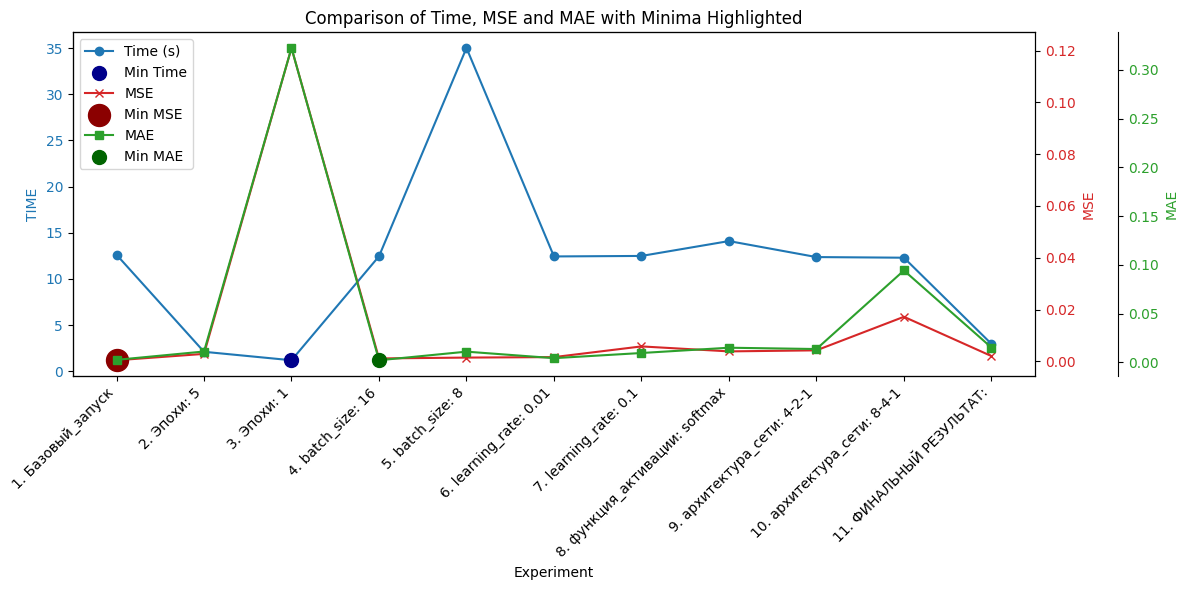

In [41]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))

experiments = df_results['Experiment']

# TIME
ax1.set_xlabel('Experiment')
ax1.set_ylabel('TIME', color='tab:blue')
ax1.plot(experiments, df_results['TIME'], color='tab:blue', marker='o', label='Time (s)')
ax1.tick_params(axis='y', labelcolor='tab:blue')
plt.xticks(rotation=45, ha='right')

min_time_idx = df_results['TIME'].idxmin()
ax1.scatter(experiments[min_time_idx], df_results['TIME'][min_time_idx], 
            color='darkblue', s=100, zorder=5, label='Min Time')

# MSE
ax2 = ax1.twinx()
ax2.set_ylabel('MSE', color='tab:red')
ax2.plot(experiments, df_results['MSE'], color='tab:red', marker='x', label='MSE')
ax2.tick_params(axis='y', labelcolor='tab:red')

min_mse_idx = df_results['MSE'].idxmin()
ax2.scatter(experiments[min_mse_idx], df_results['MSE'][min_mse_idx], 
            color='darkred', s=250, zorder=5, label='Min MSE')

# MAE
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('MAE', color='tab:green')
ax3.plot(experiments, df_results['MAE'], color='tab:green', marker='s', label='MAE')
ax3.tick_params(axis='y', labelcolor='tab:green')

min_mae_idx = df_results['MAE'].idxmin()
ax3.scatter(experiments[min_mae_idx], df_results['MAE'][min_mae_idx], 
            color='darkgreen', s=100, zorder=5, label='Min MAE')

lines, labels = [], []
for ax in [ax1, ax2, ax3]:
    line, label = ax.get_legend_handles_labels()
    lines += line
    labels += label
ax1.legend(lines, labels, loc='upper left')

plt.title('Comparison of Time, MSE and MAE with Minima Highlighted')
plt.tight_layout()
plt.show()


In [58]:
INPUT_MSC_JSON = "data/full_data_MSC.json"
OUTPUT_MSC_CSV = "data/osm_nodes_MSC.csv"

with open(INPUT_MSC_JSON, "r", encoding="utf-8") as f:
    data = json.load(f)

nodes = [el for el in data.get("elements", []) if el.get("type") == "node"]

tag_keys = []
for node in nodes:

    x = node.get("tags", {}).get("tourism", {})
    if x == "yes":
        tag_keys.append("tourism")
    elif x != "no":
        tag_keys.append(node.get("tags", {}).get("tourism", {}))
    
    x = node.get("tags", {}).get("historic", {})
    if x == "yes":
        tag_keys.append("historic")
    elif x != "no":
        tag_keys.append(node.get("tags", {}).get("historic", {}))

    x = node.get("tags", {}).get("amenity", {})
    if x == "yes":
        tag_keys.append("amenity")
    elif x != "no":
        tag_keys.append(node.get("tags", {}).get("amenity", {}))

    x = node.get("tags", {}).get("leisure", {})
    if x == "yes":
        tag_keys.append("leisure")
    elif x != "no":
        tag_keys.append(node.get("tags", {}).get("leisure", {}))

tags = set()

prefs_keys = prefs.keys()
# for i in tag_keys:
#     if i != {}:
#         if i in prefs.keys():
#             tags.add(i)
tags = set(prefs.keys())

print("Всего тегов:",len(tags))
print("Теги:",tags)

Всего тегов: 79
Теги: {'viewpoint', 'train', 'theme_park', 'vehicle', 'locomotive', 'water_park', 'shield', 'guest_house', 'zoo', 'dog_park', 'fountain', 'picnic_site', 'anchor', 'manor', 'technical_monument', 'hostel', 'wreck', 'historic', 'picnic_table', 'monument', 'tomb', 'motel', 'cannon', 'aircraft', 'gate', 'ruins', 'ship', 'museum', 'castle', 'hotel', 'gallery', 'chalet', 'wayside_cross', 'railway_station', 'attraction', 'apartment', 'hospital', 'epigraph', 'binoculars', 'training', 'garden', 'tank', 'propeller', 'archaeological_site', 'mine', 'social_facility', 'cafe', 'city_gate', 'church', 'dormitory', 'camp_site', 'battlefield', 'library', 'suburb', 'sauna', 'amusement_arcade', 'missile', 'railway_car', 'trail_riding_station', 'swimming_pool', 'boundary_stone', 'cross', 'restaurant', 'memorial', 'milestone', 'information', 'stone', 'printing_press', 'place_of_worship', 'lean_to', 'bench', 'grave', 'statue', 'artwork', 'wayside_shrine', 'aquarium', 'caravan_site', 'exhibit',

In [59]:
fieldnames = ["id", "lat", "lon", "name", "description", "inscription"] + sorted(tags)

with open(OUTPUT_MSC_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()

    for node in nodes:
        row = {
            "id": node.get("id"),
            "lat": node.get("lat"),
            "lon": node.get("lon")
        }
        row["name"] = node.get("tags").get("name")
        row["description"] = node.get("tags").get("description")
        row["inscription"] = node.get("tags").get("inscription")
        

        if row["name"] == None:
            row["name"] = row["description"]

        if row["description"] == None:
            row["description"] = row["inscription"]

        if row["inscription"] == None:
            row["inscription"] = row["name"]

        if row["description"] == None:
            row["description"] = row["inscription"]
        
        if row["name"] == None:
            row["name"] = "Место-сюрприз"
        if row["description"] == None:
            row["description"] = "Место-сюрприз"
        if row["inscription"] == None:
            row["inscription"] = "Место-сюрприз"

        for key in tags:
            if(node.get("tags", {}).get(key, "")):
                row[key] = True
            else:
                row[key] = False
        writer.writerow(row)

print(f"Сохранено {len(nodes)} нод в {OUTPUT_MSC_CSV}")

Сохранено 11404 нод в data/osm_nodes_MSC.csv


In [60]:
df = pd.read_csv(OUTPUT_MSC_CSV, encoding="utf-8")

# df[binary_cols] = df[binary_cols].astype("int8")

df.info()
df.head()

# base_cols = {"id", "lat", "lon", "name", "description", "inscription"}
# binary_cols = [c for c in df.columns if c not in base_cols]
# df[binary_cols].sum().sort_values(ascending=False).head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11404 entries, 0 to 11403
Data columns (total 85 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    11404 non-null  int64  
 1   lat                   11404 non-null  float64
 2   lon                   11404 non-null  float64
 3   name                  11404 non-null  object 
 4   description           11404 non-null  object 
 5   inscription           11404 non-null  object 
 6   aircraft              11404 non-null  bool   
 7   amusement_arcade      11404 non-null  bool   
 8   anchor                11404 non-null  bool   
 9   apartment             11404 non-null  bool   
 10  aquarium              11404 non-null  bool   
 11  archaeological_site   11404 non-null  bool   
 12  artwork               11404 non-null  bool   
 13  attraction            11404 non-null  bool   
 14  battlefield           11404 non-null  bool   
 15  bench              

,id,lat,lon,name,description,inscription,aircraft,amusement_arcade,anchor,apartment,...,trail_riding_station,train,training,vehicle,viewpoint,water_park,wayside_cross,wayside_shrine,wreck,zoo
0,101124656,55.776613,37.623175,Храм Сергия Радонежского в Троицком Подворье,Храм Сергия Радонежского в Троицком Подворье,Храм Сергия Радонежского в Троицком Подворье,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,241895605,55.748944,37.612410,Боровицкие ворота,Боровицкие ворота,Боровицкие ворота,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,249719606,55.689419,37.676835,Южный речной вокзал,Южный речной вокзал,Южный речной вокзал,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,250525422,55.822676,37.639719,Покорителям космоса,Покорителям космоса,Покорителям космоса,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,252934686,55.754611,37.633933,Кириллу и Мефодию,Кириллу и Мефодию,Кириллу и Мефодию,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [61]:
import random
random.seed(10)

poi_cols = [col for col in prefs.keys() if col in df.columns]

poi_matrix = df[poi_cols]

weights = pd.Series([prefs[col] for col in poi_cols], index=poi_cols)

df['score'] = poi_matrix.dot(weights) + random.uniform(-2.0, 2.0)

df[['id', 'name', 'score'] + poi_cols].head()

,id,name,score,historic,archaeological_site,ruins,battlefield,memorial,milestone,boundary_stone,...,cross,wayside_shrine,tomb,grave,attraction,picnic_site,picnic_table,trail_riding_station,suburb,sauna
0,101124656,Храм Сергия Радонежского в Троицком Подворье,0.285610,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,241895605,Боровицкие ворота,2.285610,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,249719606,Южный речной вокзал,0.285610,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,250525422,Покорителям космоса,2.285610,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,252934686,Кириллу и Мефодию,4.285610,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [62]:
train_idx, test_idx = train_test_split(
    df.index,
    test_size=0.999,
    random_state=42,
    shuffle=True
)

df['split'] = 'train'
df.loc[test_idx, 'split'] = 'test'
df['split'].value_counts()

split
test     11393
train       11
Name: count, dtype: int64

In [63]:
N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

df['fold'] = -1

for fold_number, (_, test_idx) in enumerate(kf.split(df)):
    df.loc[test_idx, 'fold'] = fold_number

df['fold'].value_counts().sort_index()

fold
0    2281
1    2281
2    2281
3    2281
4    2280
Name: count, dtype: int64

In [64]:
train_df = df[df['fold'] != 2]
test_df  = df[df['fold'] == 2]

X_train = train_df[poi_cols]
y_train = train_df['score']

X_test = test_df[poi_cols]
y_test = test_df['score']

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [65]:
results_MSC = {}

start_time = time.time()

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"Результат работы по Москве:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results_MSC["Результат работы по Москве"] = [training_time, test_loss, test_mae]

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0118 - mae: 0.0249  
Результат работы по Москве:
TIME: 0.13011956214904785
MSE: 0.0118
MAE: 0.0249


In [66]:
df_results = pd.DataFrame.from_dict(
    results_MSC, 
    orient='index', 
    columns=['TIME', 'MSE', 'MAE']
)

df_results = df_results.reset_index().rename(columns={'index': 'Experiment'})
pd.options.display.float_format = '{:.6f}'.format

df_results

,Experiment,TIME,MSE,MAE
0,Результат работы по Москве,0.130120,0.011783,0.024892
